In [22]:
!pip install pandas matplotlib scikit-learn transformers pillow tqdm tensorflow

In [55]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from PIL import Image
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

In [56]:
# Veri Yolları
data_dir = "D:/SYSTEM/CattleDataset"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")
valid_dir = os.path.join(data_dir, "valid")
train_labels = pd.read_csv("D:/SYSTEM/CattleDataset/train_classes.csv")
test_labels = pd.read_csv("D:/SYSTEM/CattleDataset/test_classes.csv")
valid_labels = pd.read_csv("D:/SYSTEM/CattleDataset/valid_classes.csv")

In [57]:
# Etiketleri birleştirme fonksiyonu
def combine_labels(row):
    labels = []
    for col in row.index[1:]:  # İlk sütun filename olduğu için hariç tutuyoruz
        if row[col] == 1:
            labels.append(col.strip())
    return ", ".join(labels) if labels else "Unlabeled"

train_labels["combined_label"] = train_labels.apply(combine_labels, axis=1)
test_labels["combined_label"] = test_labels.apply(combine_labels, axis=1)
valid_labels["combined_label"] = valid_labels.apply(combine_labels, axis=1)

In [58]:
# Hugging Face BLIP Model ve Processor Yükleme
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

In [59]:
# İlk 5 örneği gösterme
print("Train Dataset İlk 5:")
print(train_labels.head())
print("\nTest Dataset İlk 5:")
print(test_labels.head())
print("\nValid Dataset İlk 5:")
print(valid_labels.head())

Train Dataset İlk 5:
                                            filename   (BRD)   Bovine  \
0     37_jpg.rf.583270f81aad69fe1fa331edd1a8d7da.jpg       0        0   
1      8_jpg.rf.5744e632fa0e1f44d677bc5405233f02.jpg       0        0   
2     36_jpg.rf.530ca130a108b3e31c4f812330bd4211.jpg       0        0   
3  Ayrshirecattle30_c_jpg.rf.569ea435b44be8110b7c...       0        0   
4  Ayrshirecattle146_c_jpg.rf.552c1cf35f85ae054c3...       0        0   

    Contagious   Dermatitis   Disease   Ecthym   Respiratory   Unlabeled  \
0            0            0         0        0             0           0   
1            0            0         0        0             0           0   
2            0            0         0        0             0           0   
3            0            0         0        0             0           0   
4            0            0         0        0             0           0   

    healthy   lumpy   skin combined_label  
0         0       1      1    lumpy, sk

In [69]:
# Görselleri Yükleme Fonksiyonu (dönüşümü dahil)
def load_images_and_labels_with_limit(base_dir, limit_per_class=2):
    images = []
    labels = []
    for class_name in os.listdir(base_dir):
        class_path = os.path.join(base_dir, class_name)
        if os.path.isdir(class_path):  # Sadece alt klasörler
            count = 0
            for img_file in tqdm(os.listdir(class_path), desc=f"Loading images from {class_name}"):
                if count >= limit_per_class and class_name == "healthy":
                    break
                img_path = os.path.join(class_path, img_file)
                try:
                    image = Image.open(img_path).convert("RGB").resize((224, 224))
                    images.append(np.array(image))  # Numpy array olarak ekleniyor
                    labels.append(class_name)
                    count += 1
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
    return np.array(images), np.array(labels)

# Test, Train ve Valid Verilerini Yükleme
train_images, train_image_labels = load_images_and_labels_with_limit(train_dir)
valid_images, valid_image_labels = load_images_and_labels_with_limit(valid_dir)
test_images, test_image_labels = load_images_and_labels_with_limit(test_dir)

Loading images from (BRD), Disease, Ecthym: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 114.14it/s]
Loading images from Contagious, Dermatitis, lumpy, skin: 100%|██████████████████████████| 1/1 [00:00<00:00, 121.12it/s]
Loading images from Dermatitis, Ecthym, lumpy, skin: 100%|███████████████████████████████| 1/1 [00:00<00:00, 85.47it/s]
Loading images from Unlabeled: 100%|████████████████████████████████████████████████████| 1/1 [00:00<00:00, 111.85it/s]
Loading images from (BRD), Bovine, Dermatitis, Disease, healthy, lumpy: 100%|████████████| 1/1 [00:00<00:00, 98.78it/s]
Loading images from (BRD), Bovine, Disease, Respiratory: 100%|████████████████████████| 11/11 [00:00<00:00, 137.82it/s]
Loading images from lumpy, skin: 100%|████████████████████████████████████████████████| 42/42 [00:00<00:00, 125.96it/s]


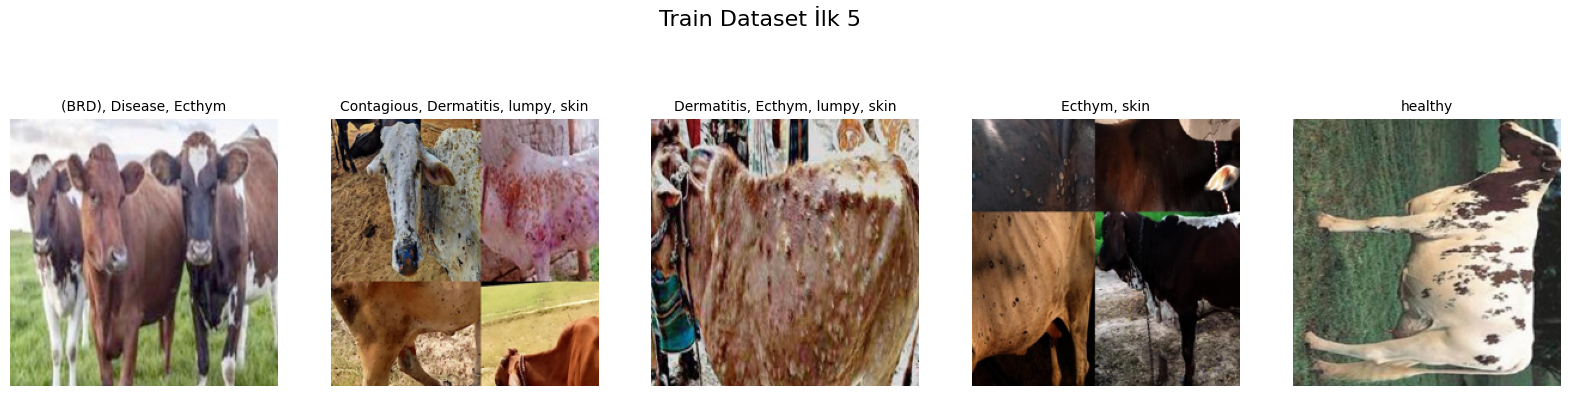

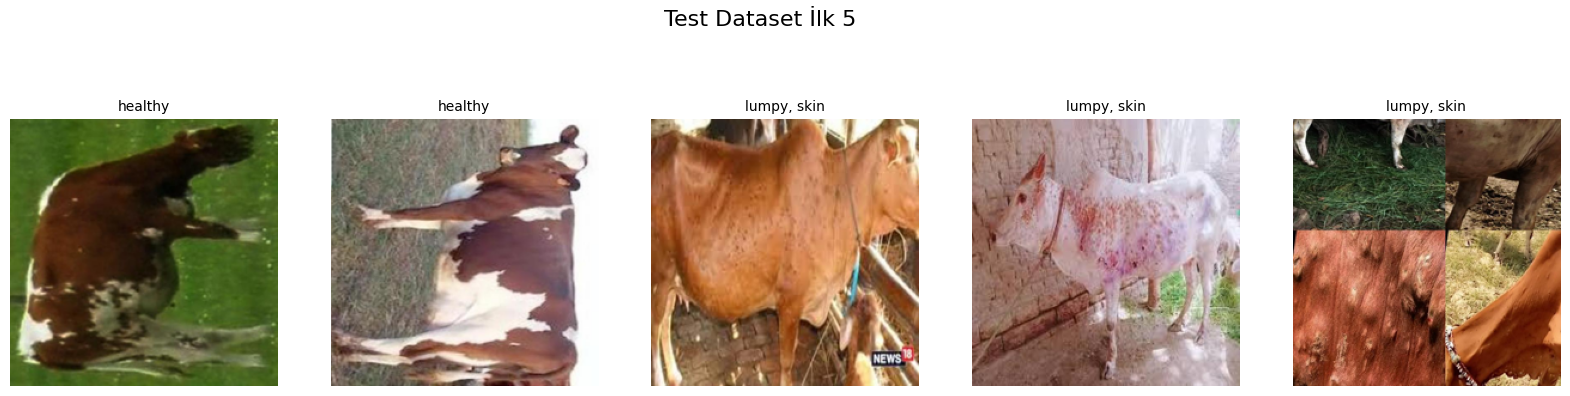

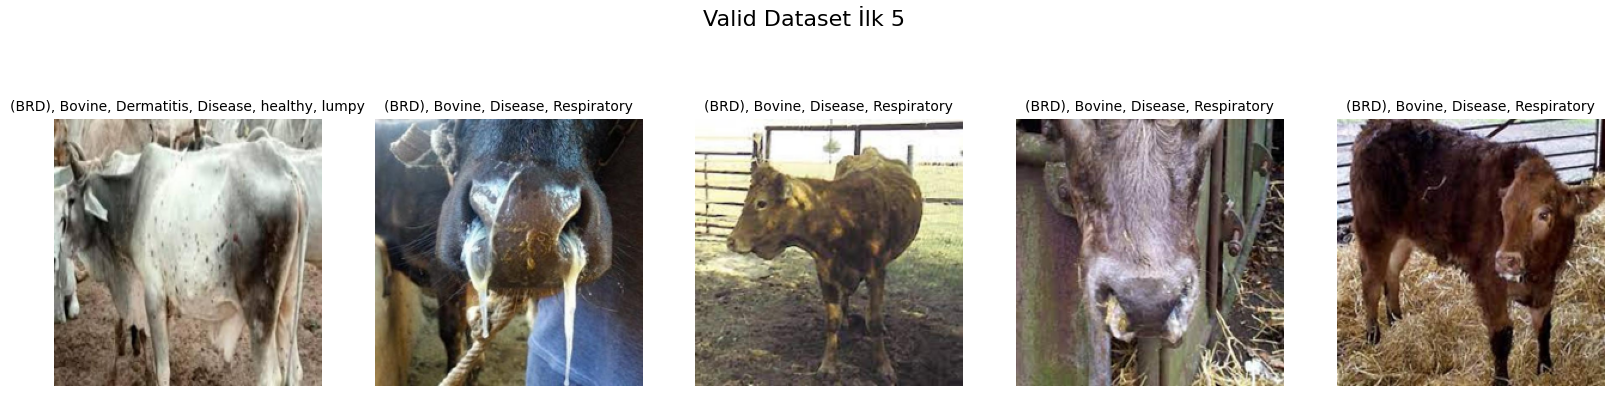

In [70]:
# Görselleri yan yana gösterme fonksiyonu
def display_images(images, labels, title):
    if len(images) == 0:
        print(f"No images to display for {title}.")
        return
    fig, axes = plt.subplots(1, min(len(images), 5), figsize=(20, 5))
    fig.suptitle(title, fontsize=16)
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.set_title(labels[i], fontsize=10)
        ax.axis('off')
    plt.show()

# İlk 5 örneği yan yana gösterme
display_images(train_images[:5], train_image_labels[:5], "Train Dataset İlk 5")
display_images(test_images[:5], test_image_labels[:5], "Test Dataset İlk 5")
display_images(valid_images[:5], valid_image_labels[:5], "Valid Dataset İlk 5")

In [62]:
# Çıkış sınıfı sayısını doğrulama
num_unique_labels = len(np.unique(train_image_labels))
assert num_unique_labels == len(set(train_image_labels)), f"Mismatch in unique labels: Found {num_unique_labels} unique labels in training data."

In [63]:
# Data Augmentation ve Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 567 images belonging to 7 classes.
Found 186 images belonging to 7 classes.
Found 81 images belonging to 2 classes.


In [64]:
from tensorflow.keras.layers import Input

# Model Oluşturma
model = Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_unique_labels, activation='softmax')
])

In [66]:
# Model Derleme
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Erken Durdurma
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Model Eğitimi
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=[early_stopping]
)

C:\Users\LordFelison\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 885ms/step - accuracy: 0.4619 - loss: 1.3790 - val_accuracy: 0.1237 - val_loss: 4.1020
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 847ms/step - accuracy: 0.5669 - loss: 0.7519 - val_accuracy: 0.3978 - val_loss: 3.9455
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 854ms/step - accuracy: 0.6111 - loss: 0.7517 - val_accuracy: 0.2634 - val_loss: 7.7117
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 828ms/step - accuracy: 0.7067 - loss: 0.6436 - val_accuracy: 0.3978 - val_loss: 4.4203
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 860ms/step - accuracy: 0.6136 - loss: 0.7797 - val_accuracy: 0.3871 - val_loss: 6.8094
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 857ms/step - accuracy: 0.7978 - loss: 0.4999 - val_accuracy: 0.3978 - val_loss: 4.8310
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 835ms/step - accuracy: 0.7316 - loss: 0.6465 - val_accuracy: 0.3978 - val_loss: 6.1652


In [67]:
# BLIP ile Görselleri Sınıflandırma
def classify_with_blip(image, prompt="Classify this cattle image into its specific category:"):
    inputs = processor(images=image, text=prompt, return_tensors="pt")
    outputs = model.generate(**inputs)
    return processor.decode(outputs[0], skip_special_tokens=True)

In [73]:
# Metrik Hesaplama
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Etiketleri sayısallaştırma
true_labels_encoded = label_encoder.fit_transform(test_image_labels)
predicted_classes_encoded = label_encoder.fit_transform(predicted_classes)

accuracy = accuracy_score(true_labels_encoded, predicted_classes_encoded)
precision = precision_score(true_labels_encoded, predicted_classes_encoded, average='weighted')
recall = recall_score(true_labels_encoded, predicted_classes_encoded, average='weighted')
f1 = f1_score(true_labels_encoded, predicted_classes_encoded, average='weighted')
conf_matrix = confusion_matrix(true_labels_encoded, predicted_classes_encoded)

print("\nDetaylı Metrikler:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Detaylı Metrikler:
Accuracy: 0.91
Precision: 0.91
Recall: 0.91
F1 Score: 0.91


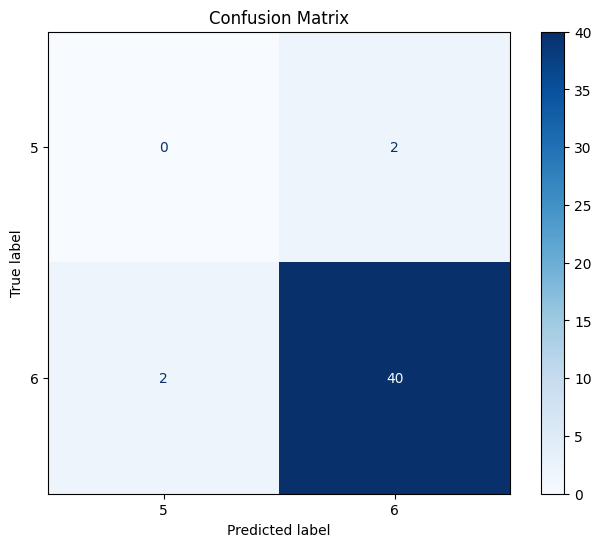

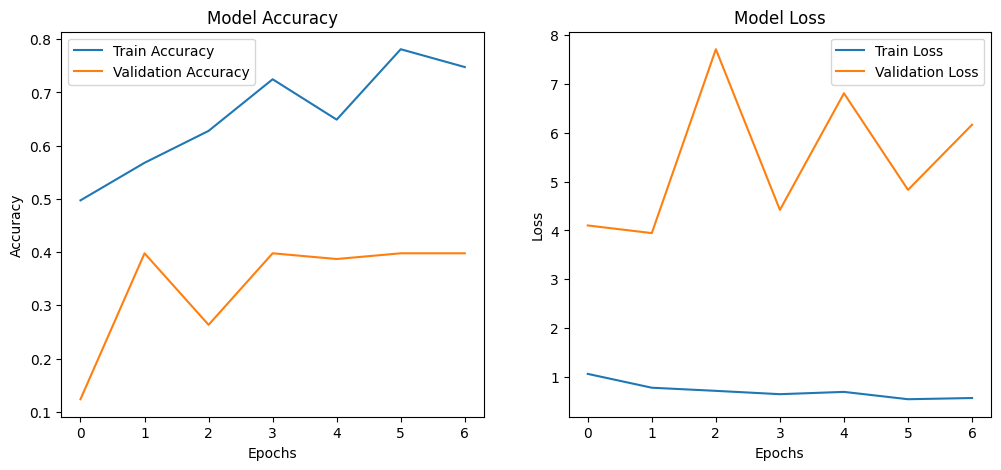

In [74]:
# Confusion Matrix Gösterimi
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title("Confusion Matrix")
plt.show()

# Eğitim ve Doğrulama Kaybı / Doğruluk Grafiği
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()